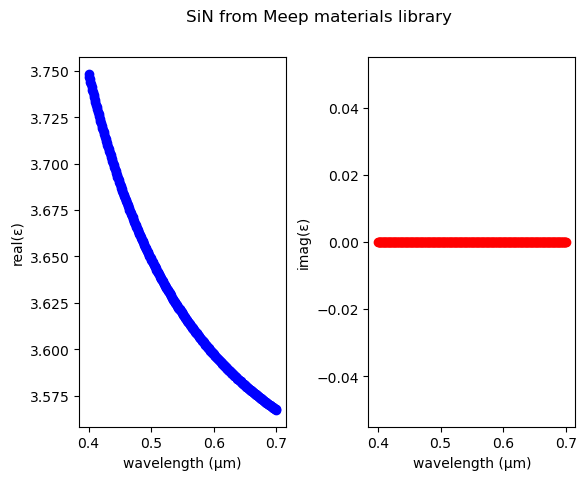

In [8]:
import meep as mp
import meep.adjoint as mpa
# from meep.materials import SiN
import numpy as np
import matplotlib.pyplot as plt

um_scale = 1
resolution = 50

SiN_frq1 = 7.7377859974045755
SiN_gam1 = 0.0
SiN_sig1 = 1.147707903082043
SiN_frq2 = 8.506180133298983
SiN_gam2 = 0.0
SiN_sig2 = 1.3401524904921767


SiN_susc = [
    mp.LorentzianSusceptibility(frequency=SiN_frq1, gamma=SiN_gam1, sigma=SiN_sig1),
    mp.LorentzianSusceptibility(frequency=SiN_frq2, gamma=SiN_gam2, sigma=SiN_sig2),
]
SiN = mp.Medium(
    epsilon=1, E_susceptibilities=SiN_susc)


wvl_min = 0.4 * um_scale# units of μm
wvl_max = 0.7 * um_scale # units of μm
nwvls = 300
wvls = np.linspace(wvl_min, wvl_max, nwvls)

SiN_epsilon = np.array([SiN.epsilon(1/w)[0][0] for w in wvls])

plt.subplot(1,2,1)
plt.plot(wvls,np.real(SiN_epsilon),'bo-')
plt.xlabel('wavelength (μm)')
plt.ylabel('real(ε)')

plt.subplot(1,2,2)
plt.plot(wvls,np.imag(SiN_epsilon),'ro-')
plt.xlabel('wavelength (μm)')
plt.ylabel('imag(ε)')

plt.suptitle('SiN from Meep materials library')
plt.subplots_adjust(wspace=0.4)
plt.savefig("epsilon")

-----------
Initializing structure...
time for choose_chunkdivision = 4.1008e-05 s
Working in 2D dimensions.
Computational cell is 10 x 10 x 0 with resolution 50
time for set_epsilon = 0.137587 s
-----------
run 0 finished at t = 16.13 (1613 timesteps)


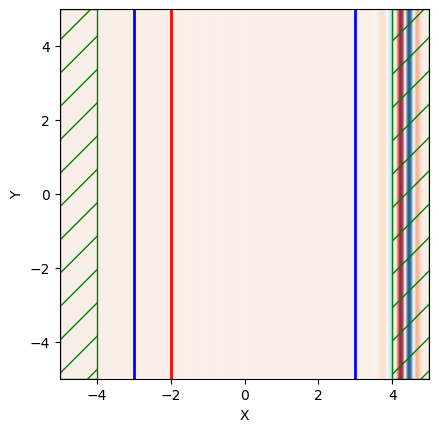

In [9]:
pml_layers = [mp.PML(thickness=1, direction = mp.X)]
cell_size = mp.Vector3(10,10)

fcen = (1/(0.40 * um_scale) + 1/(0.70 * um_scale))/2
df = 1 /(0.40 * um_scale) - 1/(0.70 * um_scale)
nfreq = 300

src = mp.GaussianSource(fcen,df)

sources = [mp.Source(src, component=mp.Ez, size=mp.Vector3(y=10), center=mp.Vector3(-2))]





geometry=[]


sim = mp.Simulation(resolution=resolution,
                    cell_size=cell_size,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=sources,
                    k_point=mp.Vector3())

# reflected flux
refl_fr = mp.FluxRegion(
    center=mp.Vector3(-3, 0, 0), size=mp.Vector3(0, 10, 0)
)
refl = sim.add_flux(fcen, df, nfreq, refl_fr)

# transmitted flux
tran_fr = mp.FluxRegion(
    center=mp.Vector3(3, 0, 0), size=mp.Vector3(0, 10, 0)
)
tran = sim.add_flux(fcen, df, nfreq, tran_fr)



sim.run(until_after_sources=mp.stop_when_dft_decayed(1e-9))

plt.figure(dpi=100)
sim.plot2D(fields=mp.Ez)
plt.show()

In [10]:
straight_refl_data = sim.get_flux_data(refl)
straight_tran_flux = mp.get_fluxes(tran)

In [11]:
sim.reset_meep()

-----------
Initializing structure...
time for choose_chunkdivision = 5.72205e-05 s
Working in 2D dimensions.
Computational cell is 10 x 10 x 0 with resolution 50
     block, center = (2,0,0)
          size (0.3,10,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.153114 s
lorentzian susceptibility: frequency=8.50618, gamma=0
lorentzian susceptibility: frequency=7.73779, gamma=0
-----------
run 0 finished at t = 20.92 (2092 timesteps)
     block, center = (2,0,0)
          size (0.3,10,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)


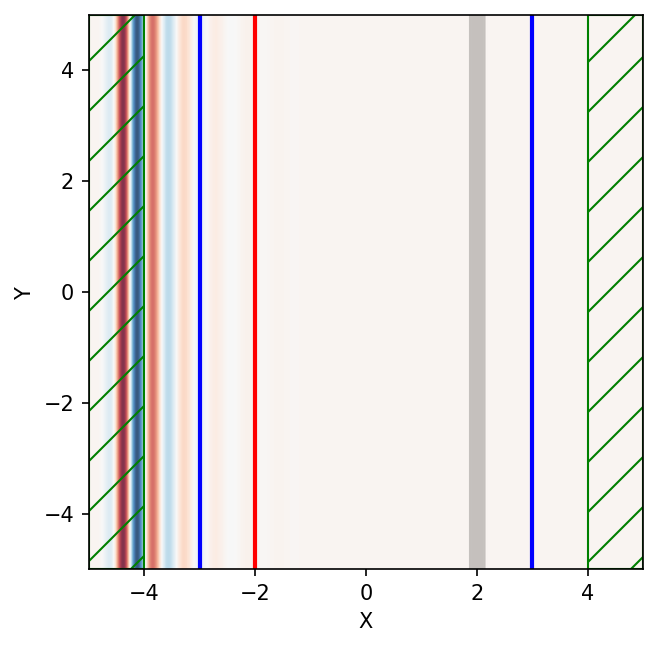

In [12]:
geometry = [mp.Block(
        mp.Vector3(0.3, 10, 0),
        center=mp.Vector3(2,0),
        material=SiN
    )]

sim = mp.Simulation(resolution=resolution,
                    cell_size=cell_size,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=sources,
                    extra_materials=[SiN],
                    k_point=mp.Vector3(0,0,0))

# reflected flux
refl = sim.add_flux(fcen, df, nfreq, refl_fr)

tran = sim.add_flux(fcen, df, nfreq, tran_fr)

# for normal run, load negated fields to subtract incident from refl. fields
sim.load_minus_flux_data(refl, straight_refl_data)

pt = mp.Vector3(4 - 0.5/resolution, 0, 0) #pt는 transmitted flux region과 동일

sim.run(until_after_sources=mp.stop_when_dft_decayed(1e-9))
# sim.run(until=100)

bend_refl_flux = mp.get_fluxes(refl)
bend_tran_flux = mp.get_fluxes(tran)

flux_freqs = mp.get_flux_freqs(refl)

plt.figure(dpi=150)
sim.plot2D(fields=mp.Ez)
plt.show()

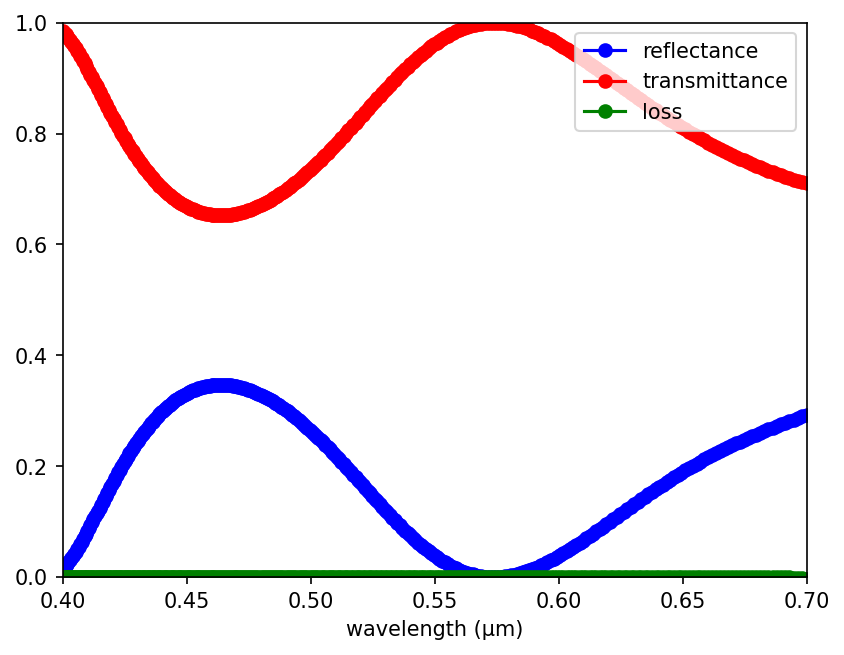

In [13]:
wl = [] #resolution 50
Rs = []
Ts = []
for i in range(nfreq):
    wl = np.append(wl, 1 / (flux_freqs[i] * um_scale))
    Rs = np.append(Rs, -bend_refl_flux[i] / straight_tran_flux[i])
    Ts = np.append(Ts, bend_tran_flux[i] / straight_tran_flux[i])

if mp.am_master():
    plt.figure(dpi=150)
    plt.plot(wl, Rs, "bo-", label="reflectance")
    plt.plot(wl, Ts, "ro-", label="transmittance")
    plt.plot(wl, 1 - Rs - Ts, "go-", label="loss")
    plt.axis([0.40, 0.70, 0, 1])
    plt.xlabel("wavelength (μm)")
    plt.legend(loc="upper right")
    plt.show()

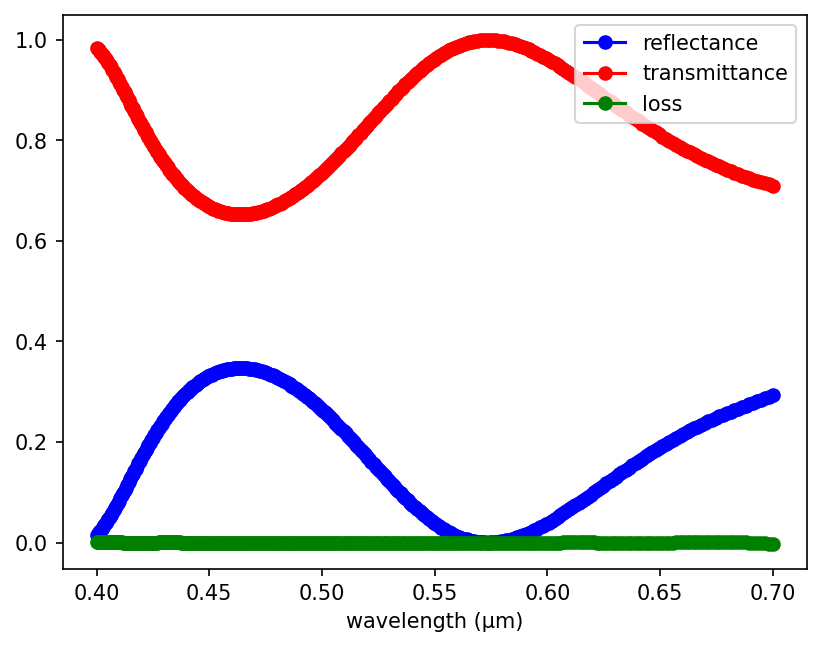

In [14]:
wl = [] #resolution20
Rs = []
Ts = []
for i in range(nfreq):
    wl = np.append(wl, 1 / (flux_freqs[i] * um_scale))
    Rs = np.append(Rs, -bend_refl_flux[i] / straight_tran_flux[i])
    Ts = np.append(Ts, bend_tran_flux[i] / straight_tran_flux[i])

if mp.am_master():
    plt.figure(dpi=150)
    plt.plot(wl, Rs, "bo-", label="reflectance")
    plt.plot(wl, Ts, "ro-", label="transmittance")
    plt.plot(wl, 1 - Rs - Ts, "go-", label="loss")
    # plt.axis([0.40, 0.70, 0, 1])
    plt.xlabel("wavelength (μm)")
    plt.legend(loc="upper right")
    plt.show()